## STAT 725: Advanced Machine Learning - Daniel Tiourine

## Spring 2025 Final Project: Image Classification

Stanford Dogs Dataset is an image dataset for developing deep learning algorithms and specific techniques in the classification of dog breed images. This dataset consists of 20,580 images classified in 120 categories representing different dog breeds including: Afghan Hound: 199 images; African Wild Dog: 168 images; Airedale Terrier: 181 images; American Staffordshire Terrier: 183 images; Appenzeller Sennenhund: 143 images; Australian Terrier: 152 images; Basenji: 168 images; Basset Hound: 155 images; Beagle: 174 images; Bedlington Terrier: 142 images; Bernese Mountain Dog: 180 images; Blenheim Spaniel: 159 images; Bloodhound: 134 images; and so on...

Dataset link: http://vision.stanford.edu/aditya86/ImageNetDogs/


## Downloading the data

In [1]:
import os
import requests
import tarfile

os.makedirs('stanford_dogs', exist_ok=True)
os.chdir('stanford_dogs')

image_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
annotation_url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar'

print("Downloading images...")
r = requests.get(image_url, stream=True)
with open('images.tar', 'wb') as f:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)
            
print("Downloading annotations...")
r = requests.get(annotation_url, stream=True)
with open('annotation.tar', 'wb') as f:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)

print("Extracting images...")
with tarfile.open('images.tar') as tar:
    tar.extractall()
    
print("Extracting annotations...")
with tarfile.open('annotation.tar') as tar:
    tar.extractall()

print("Download and extraction complete!")

Extracting images...
Extracting annotations...
Download and extraction complete!


## Splitting the data into separate train, val, and test sets

We begin by creating directories to separate the train, val, and test sets as well as the different breeds within each set.

In [2]:
data_dir = ''
images_dir = os.path.join(data_dir, 'Images')

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)
    
breed_dirs = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]
for split_dir in [train_dir, val_dir, test_dir]:
    for breed in breed_dirs:
        os.makedirs(os.path.join(split_dir, breed), exist_ok=True)

Next, we define the train, val, and test split ratios and move the files to the folders we created above.

In [3]:
from sklearn.model_selection import train_test_split
import glob 
from shutil import copyfile

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for breed in breed_dirs:
    breed_path = os.path.join(images_dir, breed)
    image_files = glob.glob(os.path.join(breed_path, '*.jpg'))
    
    # First split: train and temp (val + test combined)
    train_files, temp_files = train_test_split(image_files, test_size=(val_ratio + test_ratio), random_state=6671)
    
    # Second split: divide temp into val and test
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio/(val_ratio + test_ratio), random_state=6671)
    
    # Copy files to respective directories
    for file in train_files:
        filename = os.path.basename(file)
        copyfile(file, os.path.join(train_dir, breed, filename))
    
    for file in val_files:
        filename = os.path.basename(file)
        copyfile(file, os.path.join(val_dir, breed, filename))
    
    for file in test_files:
        filename = os.path.basename(file)
        copyfile(file, os.path.join(test_dir, breed, filename))

In [4]:
print(f"Dataset split complete: {len(breed_dirs)} breeds")
train_count = sum(len(os.listdir(os.path.join(train_dir, d))) for d in breed_dirs)
print(f"Train samples: {train_count}")
val_count = sum(len(os.listdir(os.path.join(val_dir, d))) for d in breed_dirs)
print(f"Validation samples: {val_count}")
test_count = sum(len(os.listdir(os.path.join(test_dir, d))) for d in breed_dirs)
print(f"Test samples: {test_count}")

Dataset split complete: 120 breeds
Train samples: 14357
Validation samples: 3082
Test samples: 3141


Optionally, we can get rid of the other data folders and files (e.g `/Annotation`, `/Images`, `annotation.tar`, etc.) to clean up our data directory:

In [5]:
import shutil

if train_count + val_count + test_count > 15000:  
    print("Splits look good. Cleaning up redundant files...")
    
    # List of directories and files to remove
    to_remove = [
        os.path.join(data_dir, 'Annotation'),
        os.path.join(data_dir, 'Images'),
        os.path.join(data_dir, 'stanford_dogs'),  # The nested directory
        os.path.join(data_dir, 'annotation.tar'),
        os.path.join(data_dir, 'images.tar')
    ]
    
    # Ask for confirmation
    print("Will remove these directories and files:")
    for item in to_remove:
        if os.path.exists(item):
            print(f"- {item} ({'directory' if os.path.isdir(item) else 'file'})")
    
    confirm = input("Are you sure you want to delete these? (yes/no): ")
    
    if confirm.lower() == 'yes':
        # Proceed with deletion
        for item in to_remove:
            if os.path.exists(item):
                if os.path.isdir(item):
                    shutil.rmtree(item)
                    print(f"Removed directory: {item}")
                else:
                    os.remove(item)
                    print(f"Removed file: {item}")
        print("Cleanup complete!")
    else:
        print("Cleanup cancelled.")
else:
    print("Warning: Your train/val/test splits may not have enough images.")
    print("Double-check before removing the original files.")

Splits look good. Cleaning up redundant files...
Will remove these directories and files:
- Annotation (directory)
- Images (directory)
- annotation.tar (file)
- images.tar (file)
Removed directory: Annotation
Removed directory: Images
Removed file: annotation.tar
Removed file: images.tar
Cleanup complete!


## Exploring the data: displaying an image

In [6]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [7]:
image_path = os.path.join('train', 'n02085620-Chihuahua', 'n02085620_242.jpg')
pic_1 = plt.imread(image_path)

In [8]:
print('Data shape:', pic_1.shape)
print('Data type:', type(pic_1))

Data shape: (500, 400, 3)
Data type: <class 'numpy.ndarray'>


In [9]:
pic_1 = pic_1 / 255  # dividing by 255 to normalize and get values between 0 and 1

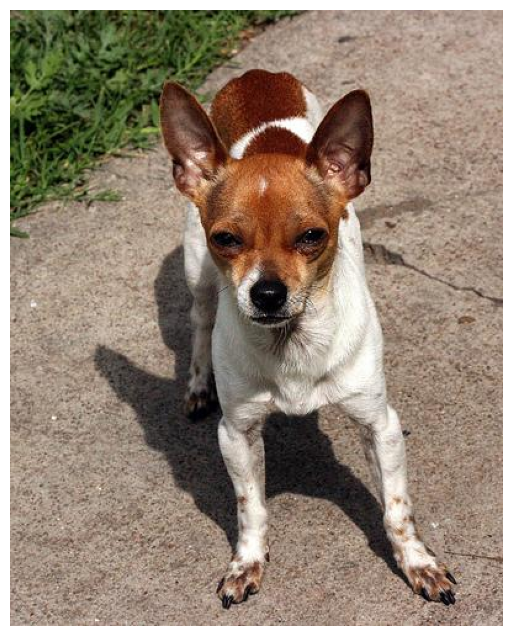

In [10]:
plt.figure(figsize=(8, 8))
plt.imshow(pic_1)
plt.axis('off')
plt.show()

## Exploring the data: displaying 5 random images across all classes

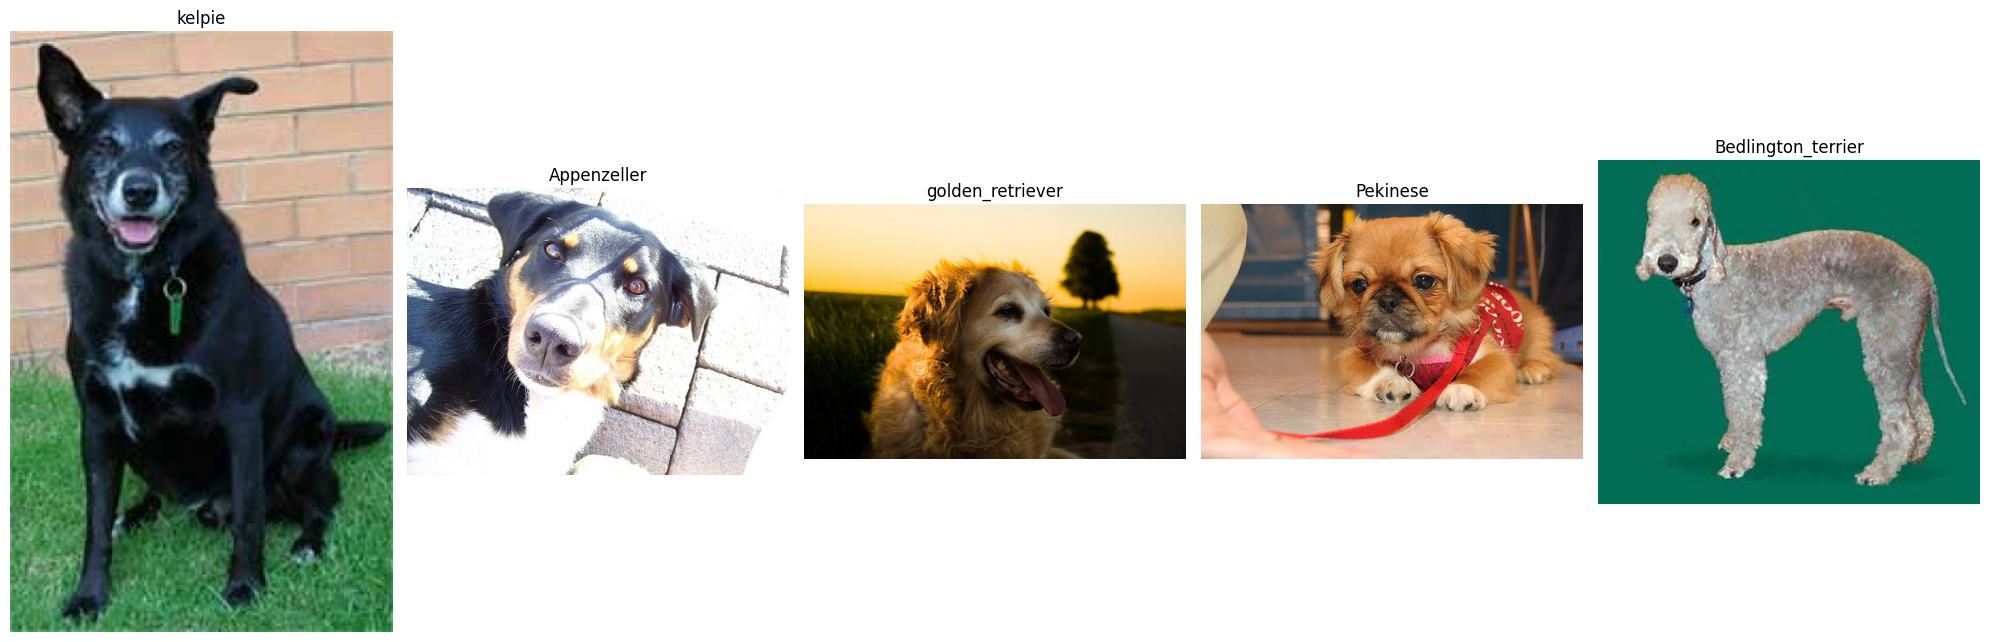

In [11]:
import random
random.seed(6671) # Last 4 digits of my EMPLID, but remove this if you want truly random

classes = os.listdir(train_dir)
classes = [cls for cls in classes if os.path.isdir(os.path.join(train_dir, cls))]
selected_classes = random.sample(classes, 5)

plt.figure(figsize=(20, 20))

for i, dog_breed in enumerate(selected_classes):
    img_folder = os.path.join(train_dir, dog_breed)
    
    image_files = [f for f in os.listdir(img_folder) if f.endswith('.jpg') or f.endswith('.png')]
    
    file_name = random.choice(image_files)
    img_path = os.path.join(img_folder, file_name)
    
    img = plt.imread(img_path)
    ax = plt.subplot(1, 5, i+1)
    
    breed_name = dog_breed.split('-')[-1] if '-' in dog_breed else dog_breed
    ax.title.set_text(breed_name)
    
    plt.imshow(img)
    
    plt.axis('off')

plt.tight_layout()
plt.show()

## Preprocessing the data

Now that we have successfully downloaded, split, and looked at our data, we can begin preprocessing. This involves:

- Resizing the data (e.g sharing a common size of 224 x 224)
- Normalizing pixel values to range from 0-1
- Data augmentation to artifically expand the training dataset

More specifically, our data augmentation techniques will include:
- Random horizontal flips
- Random brightness adjustment
- Random contrast adjustment
- Random saturation adjustment

In [12]:
import tensorflow as tf

# Define parameters
img_height, img_width = 224, 224
batch_size = 32

classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

2025-05-19 11:19:40.828996: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 11:19:40.959413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747667981.011631   12995 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747667981.027594   12995 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 11:19:41.154759: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [13]:
from tensorflow.keras.applications.resnet50 import preprocess_input

def process_path(file_path):
    # Extract class name and get label
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2] 
    label_idx = tf.argmax(tf.cast(tf.equal(classes, label), tf.int32))
    
    # Read and decode the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.cast(img, tf.float32)  # Convert to float32 but DON'T preprocess yet
    
    # One-hot encode label
    label_one_hot = tf.one_hot(label_idx, depth=len(classes))
    
    return img, label_one_hot

In [14]:
def augment_raw(image, label):
    # Do augmentation on the RAW image (before preprocessing)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    
    # Clip to valid image range after augmentation
    # image = tf.clip_by_value(image, 0.0, 255.0)
    
    image = preprocess_input(image)
    
    return image, label

In [15]:
# Create training dataset
train_files = tf.data.Dataset.list_files(str(train_dir + '/*/*.jpg'), shuffle=True)
train_ds = train_files.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment_raw, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# For validation, apply preprocessing but no augmentation
def preprocess_only(image, label):
    image = preprocess_input(image)
    return image, label

# Create validation dataset - no augmentation
val_files = tf.data.Dataset.list_files(str(val_dir + '/*/*.jpg'), shuffle=False)
val_ds = val_files.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_only, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create test dataset - no augmentation
test_files = tf.data.Dataset.list_files(str(test_dir + '/*/*.jpg'), shuffle=False)
test_ds = test_files.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_only, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1747667983.188023   12995 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


## Visualize Preprocessed Images

Now that we have preprocessed and augmented our images, let's visualize them to make sure everything looks correct:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-57.768803..73.27994].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-61.179417..80.52559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-56.979935..70.41588].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-53.966785..60.8737].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-70.03079..91.03406].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-55.19625..66.55063].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-46.86613..68.7306

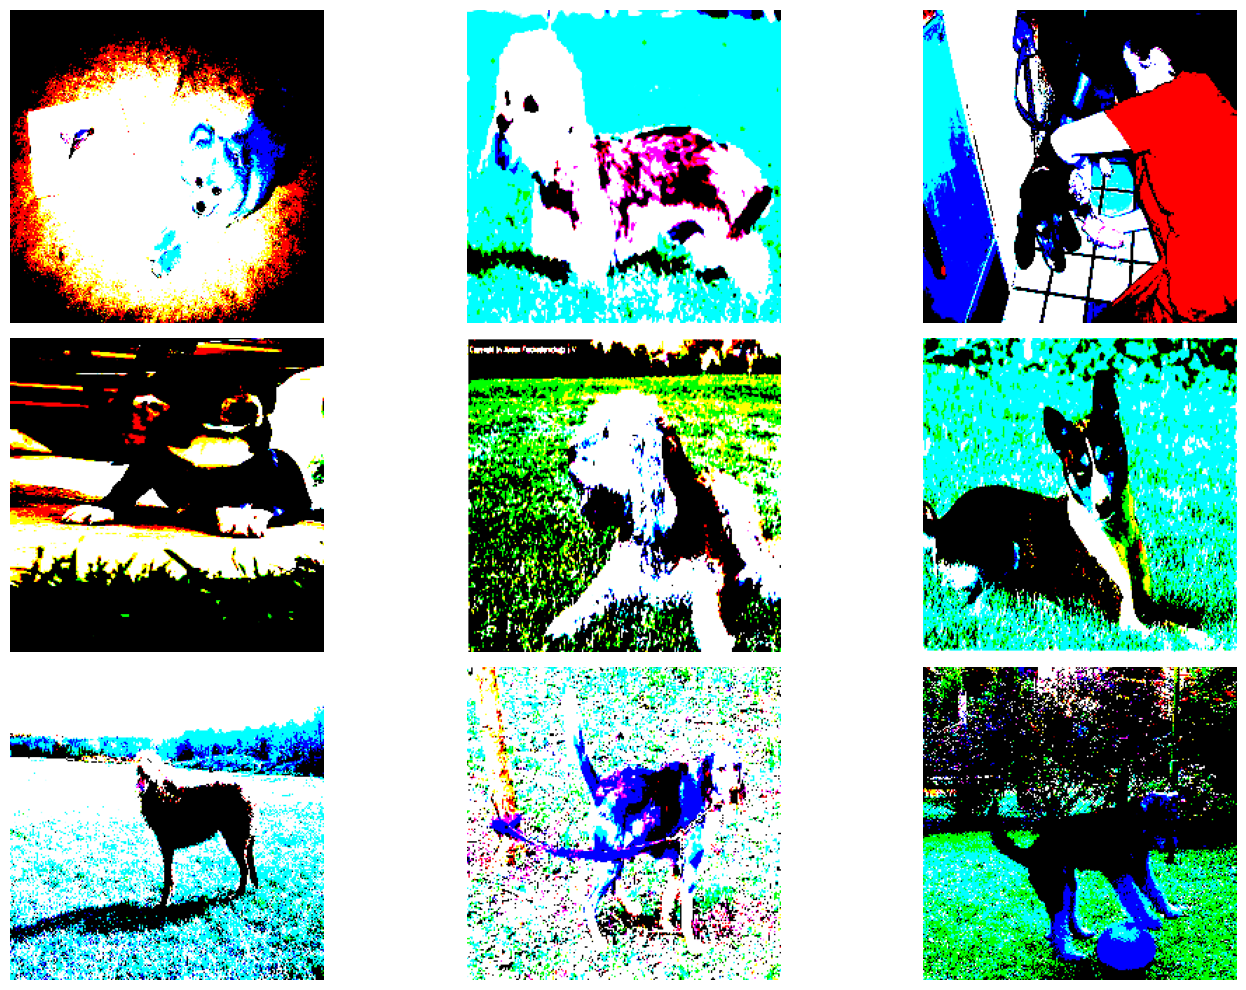

In [16]:
for images, labels in train_ds.take(1):  # Take one batch
    # Display a few images
    plt.figure(figsize=(15, 10))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i+1)
        
        img = images[i].numpy()
        
        if img.min() < 0:
            img = (img + 1) / 2
            
        plt.imshow(img)
        
        if len(labels[i].shape) > 0:  
            class_idx = np.argmax(labels[i].numpy())
        else: 
            class_idx = int(labels[i].numpy())
                
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    break

**Note: The colors and RGB channels are messed up, but this is actually expected - ResNet50's preprocessing does channel reversal and subtracts the ImageNet means from each channel, which is altering the appearance. So although the images look weird to the human eye, they are actually preprocessed correctly for the ML model**

## Setting Up Callback

Finally, now that our data is preprocessed and ready to work with, we can begin training. But first, let's set up callbacks like early stopping and checkpoints:

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, early_stopping]

## Model 1 - Transfer Learning with ResNet50

In [37]:
num_classes = len([f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))])
img_height, img_width = 224, 224
batch_size = 32
print(f"Number of classes: {num_classes}")

Number of classes: 120


In [38]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import  GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
    
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(640, activation='relu', kernel_regularizer=l2(0.0015))(x) 
x = BatchNormalization()(x)
x = Dropout(0.65)(x)  
x = Dense(320, activation='relu', kernel_regularizer=l2(0.0015))(x)
x = BatchNormalization()(x)
x = Dropout(0.65)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [39]:
model.compile(
    optimizer=Adam(learning_rate=0.0002), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0362 - loss: 7.7951
Epoch 1: val_accuracy did not improve from 0.80921
449/449 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.0363 - loss: 7.7932 - val_accuracy: 0.5743 - val_loss: 4.0738
Epoch 2/20
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2443 - loss: 5.2315
Epoch 2: val_accuracy did not improve from 0.80921
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.2445 - loss: 5.2304 - val_accuracy: 0.7038 - val_loss: 3.2653
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3936 - loss: 4.2793
Epoch 3: val_accuracy did not improve from 0.80921
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.3936 - loss: 4.2790 - val_accuracy: 0.7395 - val_loss: 2.9129
Epoch 4/20
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4822 - loss: 3.7425
Epoch 4: val_accuracy did not improve from 0.80921
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.4822 - loss: 3.7422 - val_accuracy

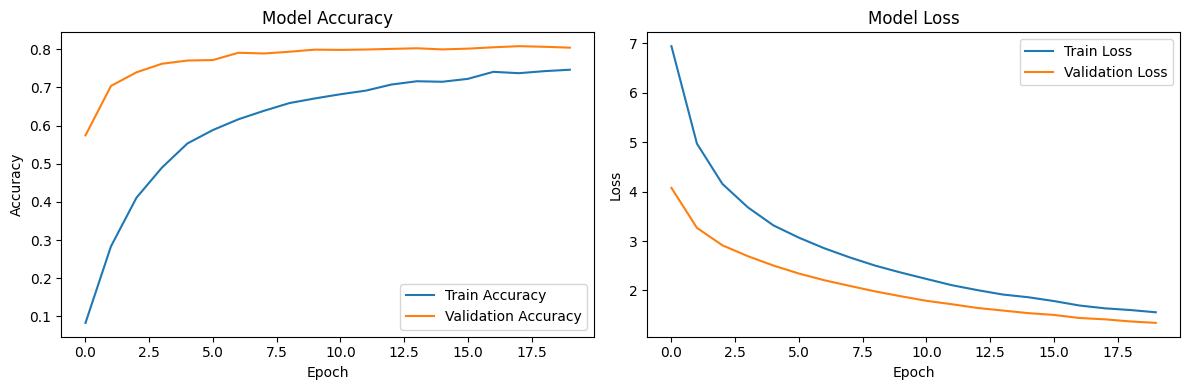

Best validation accuracy: 0.8079


In [41]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print best validation accuracy achieved
best_val_acc = max(history.history['val_accuracy'])
print(f"Best validation accuracy: {best_val_acc:.4f}")

After plotting the model accuracy and model loss, we see that at some point the training accuracy/training loss becomes much better than the validation accuracy and validation loss, indicating **overfitting**.

Now, we unfreeze some layers to begin finetuning.

In [42]:
# Fine-tuning phase: unfreeze some layers
for layer in base_model.layers[-20:]:  
    layer.trainable = True

In [43]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_checkpoint = ModelCheckpoint(
    'fine_tuned_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

fine_tune_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

fine_tune_callbacks = [fine_tune_checkpoint, fine_tune_early_stopping]

In [44]:
fine_tune_history = model.fit(
    train_ds,
    epochs=40, 
    validation_data=val_ds,
    callbacks=fine_tune_callbacks,
    initial_epoch=history.epoch[-1] + 1  # Continue from where we left off
)

Epoch 21/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7206 - loss: 1.6926
Epoch 21: val_accuracy improved from -inf to 0.80500, saving model to fine_tuned_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - accuracy: 0.7206 - loss: 1.6925 - val_accuracy: 0.8050 - val_loss: 1.3779
Epoch 22/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7487 - loss: 1.5704
Epoch 22: val_accuracy improved from 0.80500 to 0.81019, saving model to fine_tuned_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.7488 - loss: 1.5703 - val_accuracy: 0.8102 - val_loss: 1.3580
Epoch 23/40
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7591 - loss: 1.5181
Epoch 23: val_accuracy improved from 0.81019 to 0.81278, saving model to fine_tuned_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.7591 - loss: 1.5181 - val_accuracy: 0.8128 - val_loss: 1.3468
Epoch 24/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7712 - loss: 1.4764
Epoch 24: val_accuracy improved from 0.81278 to 0.81733, saving model to fine_tuned_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.7712 - loss: 1.4764 - val_accuracy: 0.8173 - val_loss: 1.3340
Epoch 25/40
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7847 - loss: 1.4332
Epoch 25: val_accuracy improved from 0.81733 to 0.82025, saving model to fine_tuned_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.7847 - loss: 1.4332 - val_accuracy: 0.8202 - val_loss: 1.3185
Epoch 26/40
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8023 - loss: 1.3682
Epoch 26: val_accuracy did not improve from 0.82025
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.8023 - loss: 1.3682 - val_accuracy: 0.8160 - val_loss: 1.3169
Epoch 27/40
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8071 - loss: 1.3431
Epoch 27: val_accuracy did not improve from 0.82025
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.8071 - loss: 1.3431 - val_accuracy: 0.8196 - val_loss: 1.3077
Epoch 28/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8225 - loss: 1.2903
Epoch 28: val_accuracy improved from 0.82025 to 0.82154, saving model to fine_tuned_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.8225 - loss: 1.2903 - val_accuracy: 0.8215 - val_loss: 1.3063
Epoch 29/40
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8307 - loss: 1.2701
Epoch 29: val_accuracy did not improve from 0.82154
449/449 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.8307 - loss: 1.2702 - val_accuracy: 0.8189 - val_loss: 1.3061
Epoch 30/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8307 - loss: 1.2617
Epoch 30: val_accuracy did not improve from 0.82154
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8307 - loss: 1.2617 - val_accuracy: 0.8189 - val_loss: 1.3041
Epoch 31/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8416 - loss: 1.2152
Epoch 31: val_accuracy improved from 0.82154 to 0.82674, saving model to fine_tuned_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.8416 - loss: 1.2152 - val_accuracy: 0.8267 - val_loss: 1.2955
Epoch 32/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8527 - loss: 1.1853
Epoch 32: val_accuracy did not improve from 0.82674
449/449 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8527 - loss: 1.1853 - val_accuracy: 0.8189 - val_loss: 1.2979
Epoch 33/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8651 - loss: 1.1516
Epoch 33: val_accuracy did not improve from 0.82674
449/449 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.8651 - loss: 1.1516 - val_accuracy: 0.8202 - val_loss: 1.2921
Epoch 34/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8706 - loss: 1.1262
Epoch 34: val_accuracy did not improve from 0.82674
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.8706 - loss: 1.1262 - val_accuracy: 0.8183 - val_loss: 1.2897
Epoch 35/40
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8731 - loss: 1.1077
Epoch 35: val_ac

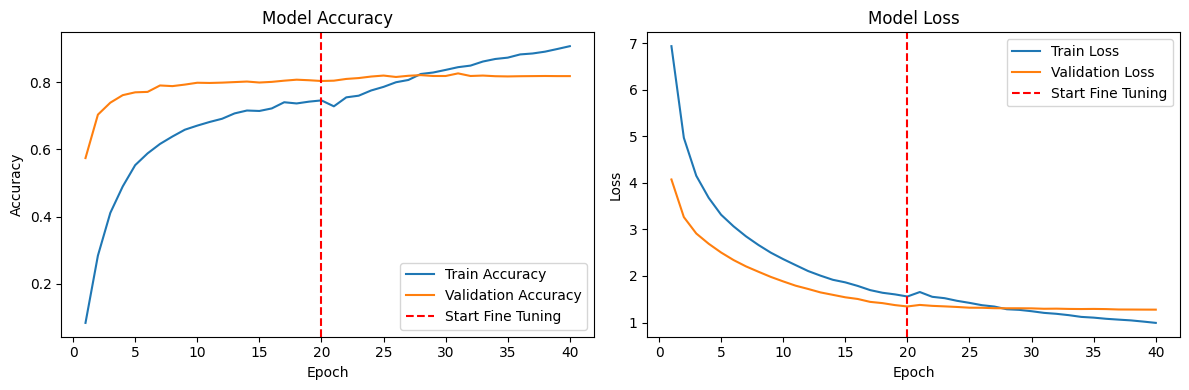

In [45]:
plt.figure(figsize=(12, 4))

# Combine the histories
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(x=len(history.history['accuracy']), color='r', linestyle='--', 
            label='Start Fine Tuning')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['loss']), color='r', linestyle='--', 
            label='Start Fine Tuning')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [33]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8196 - loss: 0.6671

2025-05-17 12:29:53.468635: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1710_0', 8 bytes spill stores, 8 bytes spill loads



99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8194 - loss: 0.6665
Test accuracy: 0.8153


## Model 2 - Simple Feed Forward Network / ANN

First, we have to adjust our preprocessing (and therefore also reload our datasets) since ANN takes flattened inputs.

In [29]:
from tensorflow.keras.applications.resnet50 import preprocess_input

def process_path_for_ann(file_path):
    # Extract class name and get label
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2] 
    label_idx = tf.argmax(tf.cast(tf.equal(classes, label), tf.int32))
    
    # Read and decode the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    
    # For ANN, normalize to [0,1] range instead of using ResNet preprocessing
    img = tf.cast(img, tf.float32) / 255.0
    
    # One-hot encode label
    label_one_hot = tf.one_hot(label_idx, depth=len(classes))
    
    return img, label_one_hot

def augment_ann(image, label):
    # Simple augmentation for ANN
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Ensure values stay in [0,1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label

In [30]:
train_files_ann = tf.data.Dataset.list_files(str(train_dir + '/*/*.jpg'), shuffle=True)
train_ds_ann = train_files_ann.map(process_path_for_ann, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_ann = train_ds_ann.map(augment_ann, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_ann = train_ds_ann.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_files_ann = tf.data.Dataset.list_files(str(val_dir + '/*/*.jpg'), shuffle=False)
val_ds_ann = val_files_ann.map(process_path_for_ann, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_ann = val_ds_ann.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_files_ann = tf.data.Dataset.list_files(str(test_dir + '/*/*.jpg'), shuffle=False)
test_ds_ann = test_files_ann.map(process_path_for_ann, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_ann = test_ds_ann.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [31]:
from tensorflow.keras import layers, models, optimizers

input_shape = [img_height, img_width, 3]

ann_model = models.Sequential([
    layers.Flatten(input_shape=input_shape),
    layers.BatchNormalization(),
    
    layers.Dense(512, activation='elu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(384, activation='elu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(256, activation='elu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(num_classes, activation='softmax')
])

ann_model.summary()

/home/developer2/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150528)         │       602,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 384)            │       196,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 120)            │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,022,008 (297.63 MB)

 Trainable params: 77,718,392 (296.47 MB)

 Non-trainable params: 303,616 (1.16 MB)

In [32]:
ann_model.compile(
    optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_ann = tf.keras.callbacks.ModelCheckpoint(
    'best_ann_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_ann = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

callbacks_ann = [checkpoint_ann, early_stopping_ann]

history_ann = ann_model.fit(
    train_ds_ann,
    epochs=50,
    validation_data=val_ds_ann,
    callbacks=callbacks_ann
)

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0113 - loss: 5.3451
Epoch 1: val_accuracy improved from -inf to 0.03115, saving model to best_ann_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.0113 - loss: 5.3445 - val_accuracy: 0.0311 - val_loss: 4.5734
Epoch 2/50
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0161 - loss: 4.7639
Epoch 2: val_accuracy did not improve from 0.03115
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0161 - loss: 4.7637 - val_accuracy: 0.0295 - val_loss: 4.5401
Epoch 3/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0193 - loss: 4.6619
Epoch 3: val_accuracy did not improve from 0.03115
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0193 - loss: 4.6618 - val_accuracy: 0.0305 - val_loss: 4.5018
Epoch 4/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0285 - loss: 4.6064
Epoch 4: val_accuracy improved from 0.03115 to 0.03212, saving model to best_ann_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.0285 - loss: 4.6063 - val_accuracy: 0.0321 - val_loss: 4.4741
Epoch 5/50
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0280 - loss: 4.5577
Epoch 5: val_accuracy improved from 0.03212 to 0.03504, saving model to best_ann_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0280 - loss: 4.5577 - val_accuracy: 0.0350 - val_loss: 4.4385
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0278 - loss: 4.5222
Epoch 6: val_accuracy improved from 0.03504 to 0.03958, saving model to best_ann_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0278 - loss: 4.5222 - val_accuracy: 0.0396 - val_loss: 4.3945
Epoch 7/50
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0340 - loss: 4.4859
Epoch 7: val_accuracy did not improve from 0.03958
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0340 - loss: 4.4859 - val_accuracy: 0.0376 - val_loss: 4.3667
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0338 - loss: 4.4643
Epoch 8: val_accuracy improved from 0.03958 to 0.04218, saving model to best_ann_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0338 - loss: 4.4642 - val_accuracy: 0.0422 - val_loss: 4.3442
Epoch 9/50
445/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0336 - loss: 4.4431
Epoch 9: val_accuracy improved from 0.04218 to 0.04964, saving model to best_ann_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0337 - loss: 4.4430 - val_accuracy: 0.0496 - val_loss: 4.3367
Epoch 10/50
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0347 - loss: 4.4207
Epoch 10: val_accuracy did not improve from 0.04964
449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.0347 - loss: 4.4207 - val_accuracy: 0.0454 - val_loss: 4.3275
Epoch 11/50
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0431 - loss: 4.4020
Epoch 11: val_accuracy did not improve from 0.04964
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0431 - loss: 4.4021 - val_accuracy: 0.0454 - val_loss: 4.3262
Epoch 12/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0381 - loss: 4.4174
Epoch 12: val_accuracy did not improve from 0.04964
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0381 - loss: 4.4174 - val_accuracy: 0.0496 - val_loss: 4.3178
Epoch 13/50
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0375 - loss: 4.3974
Epoch 13: val_accura

449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0439 - loss: 4.3647 - val_accuracy: 0.0522 - val_loss: 4.2985
Epoch 18/50
445/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0500 - loss: 4.3541
Epoch 18: val_accuracy did not improve from 0.05224
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0499 - loss: 4.3541 - val_accuracy: 0.0522 - val_loss: 4.2851
Epoch 19/50
445/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0443 - loss: 4.3412
Epoch 19: val_accuracy improved from 0.05224 to 0.05386, saving model to best_ann_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0443 - loss: 4.3412 - val_accuracy: 0.0539 - val_loss: 4.2827
Epoch 20/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0463 - loss: 4.3381
Epoch 20: val_accuracy did not improve from 0.05386
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0463 - loss: 4.3381 - val_accuracy: 0.0519 - val_loss: 4.2868
Epoch 21/50
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0421 - loss: 4.3490
Epoch 21: val_accuracy did not improve from 0.05386
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0422 - loss: 4.3490 - val_accuracy: 0.0506 - val_loss: 4.2757
Epoch 22/50
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0500 - loss: 4.3151
Epoch 22: val_accuracy did not improve from 0.05386
449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.0500 - loss: 4.3151 - val_accuracy: 0.0496 - val_loss: 4.2710
Epoch 23/50
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0504 - loss: 4.3135
Epoch 23: val_accura

449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.0506 - loss: 4.2977 - val_accuracy: 0.0545 - val_loss: 4.2623
Epoch 26/50
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0473 - loss: 4.2927
Epoch 26: val_accuracy did not improve from 0.05451
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0474 - loss: 4.2927 - val_accuracy: 0.0506 - val_loss: 4.2747
Epoch 27/50
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0539 - loss: 4.2717
Epoch 27: val_accuracy improved from 0.05451 to 0.05483, saving model to best_ann_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0538 - loss: 4.2718 - val_accuracy: 0.0548 - val_loss: 4.2605
Epoch 28/50
445/449 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0531 - loss: 4.2843
Epoch 28: val_accuracy improved from 0.05483 to 0.05516, saving model to best_ann_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.0531 - loss: 4.2844 - val_accuracy: 0.0552 - val_loss: 4.2585
Epoch 29/50
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0580 - loss: 4.2590
Epoch 29: val_accuracy did not improve from 0.05516
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0579 - loss: 4.2592 - val_accuracy: 0.0493 - val_loss: 4.2662
Epoch 30/50
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0527 - loss: 4.2500
Epoch 30: val_accuracy did not improve from 0.05516
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0527 - loss: 4.2502 - val_accuracy: 0.0529 - val_loss: 4.2627
Epoch 31/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0516 - loss: 4.2589
Epoch 31: val_accuracy did not improve from 0.05516
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0516 - loss: 4.2589 - val_accuracy: 0.0522 - val_loss: 4.2624
Epoch 32/50
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0597 - loss: 4.2548
Epoch 32: val_accura

449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0591 - loss: 4.2100 - val_accuracy: 0.0558 - val_loss: 4.2422
Epoch 39/50
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0551 - loss: 4.2185
Epoch 39: val_accuracy did not improve from 0.05581
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0551 - loss: 4.2186 - val_accuracy: 0.0519 - val_loss: 4.2481
Epoch 40/50
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0611 - loss: 4.2075
Epoch 40: val_accuracy did not improve from 0.05581
449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.0611 - loss: 4.2075 - val_accuracy: 0.0513 - val_loss: 4.2433
Epoch 41/50
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0677 - loss: 4.1911
Epoch 41: val_accuracy did not improve from 0.05581
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0677 - loss: 4.1912 - val_accuracy: 0.0545 - val_loss: 4.2467
Epoch 42/50
444/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0614 - loss: 4.1946
Epoch 42: val_accura

449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0614 - loss: 4.1947 - val_accuracy: 0.0565 - val_loss: 4.2447
Epoch 43/50
445/449 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0601 - loss: 4.1842
Epoch 43: val_accuracy did not improve from 0.05646
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0601 - loss: 4.1843 - val_accuracy: 0.0539 - val_loss: 4.2484
Epoch 44/50
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0684 - loss: 4.1734
Epoch 44: val_accuracy did not improve from 0.05646
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0684 - loss: 4.1734 - val_accuracy: 0.0545 - val_loss: 4.2547
Epoch 45/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0641 - loss: 4.1767
Epoch 45: val_accuracy did not improve from 0.05646
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0641 - loss: 4.1767 - val_accuracy: 0.0561 - val_loss: 4.2456
Epoch 46/50
445/449 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0636 - loss: 4.1735
Epoch 46: val_accura

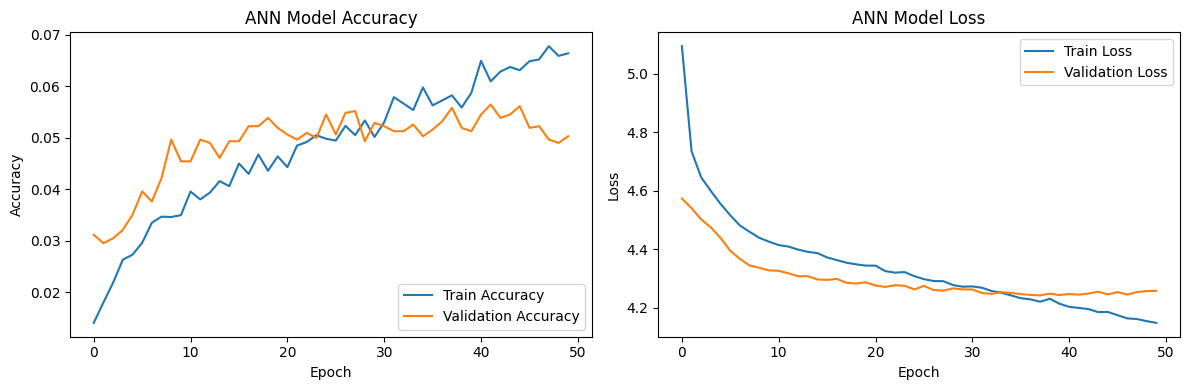

Best validation accuracy for ANN: 0.0565


In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_ann.history['loss'], label='Train Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

best_val_acc_ann = max(history_ann.history['val_accuracy'])
print(f"Best validation accuracy for ANN: {best_val_acc_ann:.4f}")

In [35]:
# Evaluate on test set
test_loss_ann, test_accuracy_ann = ann_model.evaluate(test_ds_ann)
print(f"Test accuracy for ANN: {test_accuracy_ann:.4f}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0601 - loss: 4.2645
Test accuracy for ANN: 0.0589


As we can see, the ANN performs significantly worse than the finetuned model, reaching only a 5% validation accuracy and 6% test accuracy. This is expected since ANNs have significantly more parameters than CNNs, which causes them to be much harder to train. Additionally, the Stanford Dogs Dataset is considered a challenging dataset, so it makes sense for a simple ANN to perform poorly on it.

## Model 3 - Convolutional Neural Network / CNN

In [65]:
import math

def process_path_for_cnn(file_path):
    # Extract class name and get label
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2] 
    label_idx = tf.argmax(tf.cast(tf.equal(classes, label), tf.int32))
    
    # Read and decode the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    
    # Normalize to [0,1] for CNN
    img = tf.cast(img, tf.float32) / 255.0
    
    # One-hot encode label
    label_one_hot = tf.one_hot(label_idx, depth=len(classes))
    
    return img, label_one_hot

def augment_for_cnn(image, label):

    image = tf.image.random_flip_left_right(image)
    
    padded = tf.image.resize_with_crop_or_pad(image, int(img_height*1.1), int(img_width*1.1))

    image = tf.image.random_crop(padded, [img_height, img_width, 3])
    
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label

In [70]:
# Create datasets for CNN
train_files_cnn = tf.data.Dataset.list_files(str(train_dir + '/*/*.jpg'), shuffle=True)
train_ds_cnn = train_files_cnn.map(process_path_for_cnn, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_cnn = train_ds_cnn.map(augment_for_cnn, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_cnn = train_ds_cnn.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_files_cnn = tf.data.Dataset.list_files(str(val_dir + '/*/*.jpg'), shuffle=False)
val_ds_cnn = val_files_cnn.map(process_path_for_cnn, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_cnn = val_ds_cnn.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_files_cnn = tf.data.Dataset.list_files(str(test_dir + '/*/*.jpg'), shuffle=False)
test_ds_cnn = test_files_cnn.map(process_path_for_cnn, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_cnn = test_ds_cnn.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [71]:
from tensorflow.keras import layers, models, optimizers

cnn_model = models.Sequential([

    layers.Conv2D(48, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3), 
                 kernel_regularizer=l2(0.0002)),
    layers.BatchNormalization(),
    layers.Conv2D(48, (3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.0002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(96, (3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.0002)),
    layers.BatchNormalization(),
    layers.Conv2D(96, (3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.0002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(192, (3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.0002)),
    layers.BatchNormalization(),
    layers.Conv2D(192, (3, 3), activation='relu', padding='same', 
                 kernel_regularizer=l2(0.0002)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    layers.Conv2D(64, (1, 1), activation='relu', padding='same',
                 kernel_regularizer=l2(0.0002)),
    layers.BatchNormalization(),
    
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(384, activation='relu', kernel_regularizer=l2(0.0002)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 224, 224, 48)   │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 224, 224, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 224, 224, 48)   │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 224, 224, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 112, 112, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 112, 112, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 96)   │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 112, 112, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 112, 112, 96)   │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 112, 112, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 192)    │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 56, 56, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 56, 56, 192)    │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 56, 56, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 28, 28, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 28, 28, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 64)     │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 732,776 (2.80 MB)

 Trainable params: 730,536 (2.79 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [72]:
# Compile the model
cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0008),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create callbacks
checkpoint_cnn = tf.keras.callbacks.ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_cnn = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

callbacks_cnn = [checkpoint_cnn, early_stopping_cnn]

# Train the model
history_cnn = cnn_model.fit(
    train_ds_cnn,
    epochs=100,  
    validation_data=val_ds_cnn,
    callbacks=callbacks_cnn
)

Epoch 1/100


2025-05-19 14:17:14.447166: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4870', 8 bytes spill stores, 8 bytes spill loads

2025-05-19 14:17:14.493257: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4870', 8 bytes spill stores, 8 bytes spill loads



449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.0116 - loss: 5.7946

2025-05-19 14:18:22.779647: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[10,96,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,48,112,112]{3,2,1,0}, f32[96,48,3,3]{3,2,1,0}, f32[96]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-19 14:18:22.784794: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.93862531s
Trying algorithm eng13{} for conv (f32[10,96,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,48,112,112]{3,2,1,0}, f32[96,48,3,3]{3,2,1,0}, f32[96]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_co


Epoch 1: val_accuracy improved from -inf to 0.01168, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 76s 130ms/step - accuracy: 0.0116 - loss: 5.7942 - val_accuracy: 0.0117 - val_loss: 5.0605
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0178 - loss: 5.3520
Epoch 2: val_accuracy improved from 0.01168 to 0.01817, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.0178 - loss: 5.3519 - val_accuracy: 0.0182 - val_loss: 4.9573
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0159 - loss: 5.1413
Epoch 3: val_accuracy did not improve from 0.01817
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.0159 - loss: 5.1412 - val_accuracy: 0.0133 - val_loss: 5.3268
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0200 - loss: 4.9969
Epoch 4: val_accuracy did not improve from 0.01817
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.0200 - loss: 4.9969 - val_accuracy: 0.0133 - val_loss: 5.0013
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0240 - loss: 4.8841
Epoch 5: val_accuracy improved from 0.01817 to 0.03439, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.0240 - loss: 4.8841 - val_accuracy: 0.0344 - val_loss: 4.6858
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0302 - loss: 4.7549
Epoch 6: val_accuracy improved from 0.03439 to 0.03829, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.0302 - loss: 4.7548 - val_accuracy: 0.0383 - val_loss: 4.5923
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.0368 - loss: 4.6317
Epoch 7: val_accuracy improved from 0.03829 to 0.04705, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - accuracy: 0.0368 - loss: 4.6316 - val_accuracy: 0.0470 - val_loss: 4.6296
Epoch 8/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.0537 - loss: 4.4594
Epoch 8: val_accuracy improved from 0.04705 to 0.04899, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.0537 - loss: 4.4593 - val_accuracy: 0.0490 - val_loss: 4.6059
Epoch 9/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0702 - loss: 4.2590
Epoch 9: val_accuracy did not improve from 0.04899
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.0702 - loss: 4.2589 - val_accuracy: 0.0464 - val_loss: 5.1267
Epoch 10/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.0894 - loss: 4.0543
Epoch 10: val_accuracy improved from 0.04899 to 0.09182, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.0894 - loss: 4.0543 - val_accuracy: 0.0918 - val_loss: 4.1861
Epoch 11/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1124 - loss: 3.9077
Epoch 11: val_accuracy improved from 0.09182 to 0.13660, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.1124 - loss: 3.9076 - val_accuracy: 0.1366 - val_loss: 3.8027
Epoch 12/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1366 - loss: 3.7482
Epoch 12: val_accuracy improved from 0.13660 to 0.14406, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.1366 - loss: 3.7481 - val_accuracy: 0.1441 - val_loss: 3.7184
Epoch 13/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1531 - loss: 3.6243
Epoch 13: val_accuracy did not improve from 0.14406
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.1531 - loss: 3.6243 - val_accuracy: 0.1061 - val_loss: 4.0268
Epoch 14/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1860 - loss: 3.4997
Epoch 14: val_accuracy improved from 0.14406 to 0.17975, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.1860 - loss: 3.4997 - val_accuracy: 0.1798 - val_loss: 3.5680
Epoch 15/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2035 - loss: 3.3799
Epoch 15: val_accuracy did not improve from 0.17975
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.2035 - loss: 3.3799 - val_accuracy: 0.1739 - val_loss: 3.7565
Epoch 16/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2190 - loss: 3.3070
Epoch 16: val_accuracy improved from 0.17975 to 0.21707, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.2190 - loss: 3.3070 - val_accuracy: 0.2171 - val_loss: 3.5118
Epoch 17/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2380 - loss: 3.2114
Epoch 17: val_accuracy did not improve from 0.21707
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.2380 - loss: 3.2114 - val_accuracy: 0.1460 - val_loss: 4.0139
Epoch 18/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2526 - loss: 3.1431
Epoch 18: val_accuracy did not improve from 0.21707
449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.2526 - loss: 3.1431 - val_accuracy: 0.1785 - val_loss: 4.0425
Epoch 19/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2630 - loss: 3.0729
Epoch 19: val_accuracy did not improve from 0.21707
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.2630 - loss: 3.0729 - val_accuracy: 0.1908 - val_loss: 3.8137
Epoch 20/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2879 - loss: 2.9775
Epoch 20: va

449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.2879 - loss: 2.9776 - val_accuracy: 0.2456 - val_loss: 3.3191
Epoch 21/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2975 - loss: 2.9270
Epoch 21: val_accuracy improved from 0.24562 to 0.28553, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.2975 - loss: 2.9270 - val_accuracy: 0.2855 - val_loss: 3.1407
Epoch 22/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3118 - loss: 2.8712
Epoch 22: val_accuracy did not improve from 0.28553
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.3118 - loss: 2.8712 - val_accuracy: 0.2641 - val_loss: 3.2245
Epoch 23/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3212 - loss: 2.8479
Epoch 23: val_accuracy did not improve from 0.28553
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 95ms/step - accuracy: 0.3212 - loss: 2.8479 - val_accuracy: 0.2560 - val_loss: 3.2721
Epoch 24/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3333 - loss: 2.7905
Epoch 24: val_accuracy improved from 0.28553 to 0.29040, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.3333 - loss: 2.7906 - val_accuracy: 0.2904 - val_loss: 3.1459
Epoch 25/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3372 - loss: 2.7746
Epoch 25: val_accuracy improved from 0.29040 to 0.32674, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.3372 - loss: 2.7745 - val_accuracy: 0.3267 - val_loss: 2.9276
Epoch 26/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3587 - loss: 2.7033
Epoch 26: val_accuracy improved from 0.32674 to 0.35626, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.3587 - loss: 2.7033 - val_accuracy: 0.3563 - val_loss: 2.8379
Epoch 27/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3659 - loss: 2.6549
Epoch 27: val_accuracy did not improve from 0.35626
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.3659 - loss: 2.6549 - val_accuracy: 0.3112 - val_loss: 2.9647
Epoch 28/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3713 - loss: 2.6372
Epoch 28: val_accuracy improved from 0.35626 to 0.35821, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.3713 - loss: 2.6372 - val_accuracy: 0.3582 - val_loss: 2.8537
Epoch 29/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3930 - loss: 2.5822
Epoch 29: val_accuracy did not improve from 0.35821
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.3929 - loss: 2.5822 - val_accuracy: 0.3170 - val_loss: 3.0271
Epoch 30/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3918 - loss: 2.5627
Epoch 30: val_accuracy did not improve from 0.35821
449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 99ms/step - accuracy: 0.3918 - loss: 2.5627 - val_accuracy: 0.3251 - val_loss: 2.9486
Epoch 31/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3937 - loss: 2.5655
Epoch 31: val_accuracy improved from 0.35821 to 0.39714, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.3937 - loss: 2.5655 - val_accuracy: 0.3971 - val_loss: 2.6194
Epoch 32/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4144 - loss: 2.4853
Epoch 32: val_accuracy did not improve from 0.39714
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.4144 - loss: 2.4853 - val_accuracy: 0.3803 - val_loss: 2.7255
Epoch 33/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4161 - loss: 2.4517
Epoch 33: val_accuracy did not improve from 0.39714
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.4161 - loss: 2.4518 - val_accuracy: 0.3965 - val_loss: 2.7344
Epoch 34/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4278 - loss: 2.4643
Epoch 34: val_accuracy did not improve from 0.39714
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.4277 - loss: 2.4644 - val_accuracy: 0.3751 - val_loss: 2.8111
Epoch 35/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4384 - loss: 2.4064
Epoch 35: va

449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.4528 - loss: 2.3485 - val_accuracy: 0.4062 - val_loss: 2.7390
Epoch 39/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4499 - loss: 2.3612
Epoch 39: val_accuracy did not improve from 0.40623
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.4499 - loss: 2.3613 - val_accuracy: 0.4017 - val_loss: 2.7405
Epoch 40/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4588 - loss: 2.3211
Epoch 40: val_accuracy improved from 0.40623 to 0.41759, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.4588 - loss: 2.3212 - val_accuracy: 0.4176 - val_loss: 2.5728
Epoch 41/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4628 - loss: 2.3211
Epoch 41: val_accuracy did not improve from 0.41759
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.4628 - loss: 2.3211 - val_accuracy: 0.3485 - val_loss: 3.1372
Epoch 42/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4689 - loss: 2.2998
Epoch 42: val_accuracy did not improve from 0.41759
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.4689 - loss: 2.2998 - val_accuracy: 0.3774 - val_loss: 2.9512
Epoch 43/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4765 - loss: 2.2758
Epoch 43: val_accuracy did not improve from 0.41759
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.4765 - loss: 2.2759 - val_accuracy: 0.3971 - val_loss: 2.7666
Epoch 44/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4751 - loss: 2.2658
Epoch 44: va

449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.4823 - loss: 2.2580 - val_accuracy: 0.4442 - val_loss: 2.5844
Epoch 47/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4873 - loss: 2.2560
Epoch 47: val_accuracy did not improve from 0.44419
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.4873 - loss: 2.2560 - val_accuracy: 0.4244 - val_loss: 2.6322
Epoch 48/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4962 - loss: 2.2134
Epoch 48: val_accuracy did not improve from 0.44419
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.4962 - loss: 2.2135 - val_accuracy: 0.4367 - val_loss: 2.6746
Epoch 49/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4860 - loss: 2.2605
Epoch 49: val_accuracy did not improve from 0.44419
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 97ms/step - accuracy: 0.4860 - loss: 2.2605 - val_accuracy: 0.4241 - val_loss: 2.6760
Epoch 50/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4935 - loss: 2.2202
Epoch 50: va

449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.4989 - loss: 2.1914 - val_accuracy: 0.4578 - val_loss: 2.5324
Epoch 52/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5077 - loss: 2.1634
Epoch 52: val_accuracy did not improve from 0.45782
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5077 - loss: 2.1635 - val_accuracy: 0.4526 - val_loss: 2.4864
Epoch 53/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5069 - loss: 2.1867
Epoch 53: val_accuracy did not improve from 0.45782
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.5069 - loss: 2.1868 - val_accuracy: 0.4225 - val_loss: 2.6839
Epoch 54/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5080 - loss: 2.1953
Epoch 54: val_accuracy did not improve from 0.45782
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5080 - loss: 2.1954 - val_accuracy: 0.4215 - val_loss: 2.6772
Epoch 55/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5070 - loss: 2.1862
Epoch 55: va

449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.5160 - loss: 2.1624 - val_accuracy: 0.4633 - val_loss: 2.5528
Epoch 58/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5162 - loss: 2.1635
Epoch 58: val_accuracy did not improve from 0.46334
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.5162 - loss: 2.1635 - val_accuracy: 0.4435 - val_loss: 2.6704
Epoch 59/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5307 - loss: 2.1172
Epoch 59: val_accuracy did not improve from 0.46334
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.5307 - loss: 2.1173 - val_accuracy: 0.4627 - val_loss: 2.5335
Epoch 60/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5230 - loss: 2.1165
Epoch 60: val_accuracy did not improve from 0.46334
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.5230 - loss: 2.1166 - val_accuracy: 0.4127 - val_loss: 2.7784
Epoch 61/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5249 - loss: 2.1457
Epoch 61: va

449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.5343 - loss: 2.1189 - val_accuracy: 0.4737 - val_loss: 2.4734
Epoch 65/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5380 - loss: 2.0741
Epoch 65: val_accuracy did not improve from 0.47372
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5380 - loss: 2.0742 - val_accuracy: 0.4640 - val_loss: 2.6037
Epoch 66/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5506 - loss: 2.0774
Epoch 66: val_accuracy improved from 0.47372 to 0.49027, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.5505 - loss: 2.0775 - val_accuracy: 0.4903 - val_loss: 2.4039
Epoch 67/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5330 - loss: 2.0963
Epoch 67: val_accuracy improved from 0.49027 to 0.49416, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5330 - loss: 2.0964 - val_accuracy: 0.4942 - val_loss: 2.4047
Epoch 68/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5473 - loss: 2.0700
Epoch 68: val_accuracy improved from 0.49416 to 0.49578, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.5473 - loss: 2.0700 - val_accuracy: 0.4958 - val_loss: 2.4296
Epoch 69/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5559 - loss: 2.0339
Epoch 69: val_accuracy did not improve from 0.49578
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.5559 - loss: 2.0341 - val_accuracy: 0.4685 - val_loss: 2.5683
Epoch 70/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5513 - loss: 2.0561
Epoch 70: val_accuracy did not improve from 0.49578
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.5513 - loss: 2.0561 - val_accuracy: 0.4565 - val_loss: 2.6565
Epoch 71/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5558 - loss: 2.0451
Epoch 71: val_accuracy did not improve from 0.49578
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5558 - loss: 2.0452 - val_accuracy: 0.4701 - val_loss: 2.5420
Epoch 72/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5730 - loss: 2.0351
Epoch 72: va

449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.5730 - loss: 2.0352 - val_accuracy: 0.5003 - val_loss: 2.4824
Epoch 73/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5602 - loss: 2.0395
Epoch 73: val_accuracy did not improve from 0.50032
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.5602 - loss: 2.0396 - val_accuracy: 0.4873 - val_loss: 2.5046
Epoch 74/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5542 - loss: 2.0607
Epoch 74: val_accuracy did not improve from 0.50032
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5542 - loss: 2.0608 - val_accuracy: 0.4643 - val_loss: 2.7204
Epoch 75/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5586 - loss: 2.0377
Epoch 75: val_accuracy did not improve from 0.50032
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.5586 - loss: 2.0378 - val_accuracy: 0.4825 - val_loss: 2.5343
Epoch 76/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5552 - loss: 2.0498
Epoch 76: va

449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.5628 - loss: 2.0519 - val_accuracy: 0.5068 - val_loss: 2.3965
Epoch 80/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5749 - loss: 2.0047
Epoch 80: val_accuracy did not improve from 0.50681
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5748 - loss: 2.0048 - val_accuracy: 0.5045 - val_loss: 2.3883
Epoch 81/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5691 - loss: 2.0230
Epoch 81: val_accuracy did not improve from 0.50681
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.5691 - loss: 2.0230 - val_accuracy: 0.5016 - val_loss: 2.4192
Epoch 82/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5628 - loss: 2.0270
Epoch 82: val_accuracy improved from 0.50681 to 0.51071, saving model to best_cnn_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5628 - loss: 2.0271 - val_accuracy: 0.5107 - val_loss: 2.4455
Epoch 83/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5638 - loss: 2.0282
Epoch 83: val_accuracy did not improve from 0.51071
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5638 - loss: 2.0283 - val_accuracy: 0.4961 - val_loss: 2.4323
Epoch 84/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5764 - loss: 1.9830
Epoch 84: val_accuracy did not improve from 0.51071
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.5764 - loss: 1.9831 - val_accuracy: 0.4997 - val_loss: 2.5122
Epoch 85/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5849 - loss: 1.9744
Epoch 85: val_accuracy did not improve from 0.51071
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.5849 - loss: 1.9745 - val_accuracy: 0.4860 - val_loss: 2.5760
Epoch 86/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5829 - loss: 2.0096
Epoch 86: va

449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.5713 - loss: 2.0131 - val_accuracy: 0.5240 - val_loss: 2.4410
Epoch 91/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5807 - loss: 1.9817
Epoch 91: val_accuracy did not improve from 0.52401
449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.5807 - loss: 1.9818 - val_accuracy: 0.4812 - val_loss: 2.6307
Epoch 92/100
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5851 - loss: 1.9711
Epoch 92: val_accuracy did not improve from 0.52401
449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.5850 - loss: 1.9713 - val_accuracy: 0.4822 - val_loss: 2.5690
Epoch 93/100
448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5820 - loss: 1.9803
Epoch 93: val_accuracy did not improve from 0.52401
449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.5819 - loss: 1.9804 - val_accuracy: 0.5152 - val_loss: 2.4733
Epoch 94/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5688 - loss: 1.9966
Epoch 94: va

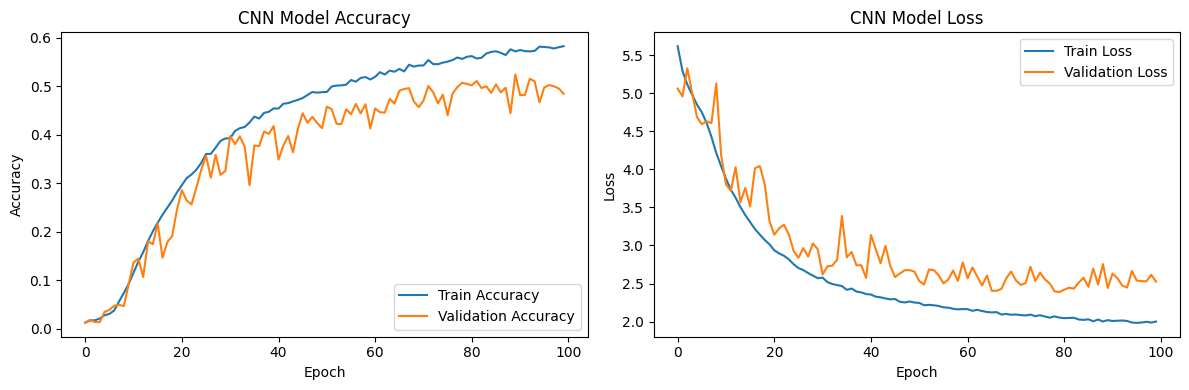

Best validation accuracy for CNN: 0.5240


In [73]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print best validation accuracy achieved
best_val_acc_cnn = max(history_cnn.history['val_accuracy'])
print(f"Best validation accuracy for CNN: {best_val_acc_cnn:.4f}")

In [74]:
# Evaluate on test set
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(test_ds_cnn)
print(f"Test accuracy for CNN: {test_accuracy_cnn:.4f}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5379 - loss: 2.4179
Test accuracy for CNN: 0.5132
